In [1]:
%matplotlib inline
import matplotlib.pyplot as plt      
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.optim import Adam

## Sine Wave to test with Wavenet

In [2]:
sine_wave = np.sin(np.arange(0, 10, 0.1))

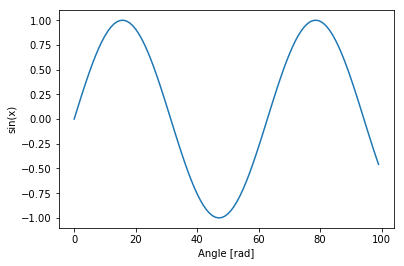

In [3]:
plt.plot(sine_wave)
plt.xlabel('Angle [rad]')
plt.ylabel('sin(x)')
plt.axis('tight');


## Encoding from the first wavenet paper, tacotron2 uses MoL encoding instead

In [4]:
def mu_law_encode(signal, mu=256):
    """
    Quantizes a signal to mu number discrete values.
    """
    mu = mu-1
    fx = np.sign(signal) * (np.log(1 + mu*np.abs(signal))/
                           np.log(1 + mu))
    return np.floor((fx+1)/2*mu+0.5).astype(np.long)


def decode_mu_law(quantized_signal, mu=256):
    mu = mu-1
    fx = (quantized_signal-0.5)/mu*2-1
    x = (np.sign(fx)/
         mu*((1+mu)**np.abs(fx)-1))
    return x


def one_hot_encode(indices, num_categories=256):
    batch_size, sequence_length = indices.size()
    one_hot = torch.zeros(batch_size, num_categories, sequence_length)
    one_hot.scatter_(1, indices.unsqueeze(dim=1), 1.0)
    return Variable(one_hot)

In [5]:
mu_sine = mu_law_encode(sine_wave)

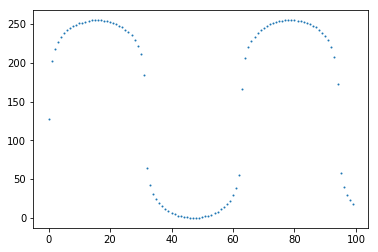

In [6]:
plt.plot(mu_sine,'.', ms=2);

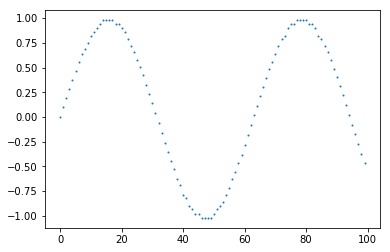

In [7]:
plt.plot(decode_mu_law(mu_sine), '.', ms=2);

In [8]:
class OneHot(nn.Module):
    """
    One hot encodes a categorical sequence
    functions similar to an embedding layer
    """
    
    def __init__(self, num_categories=256):
        super(OneHot, self).__init__()
        self.num_categories = num_categories
        
    def forward(self, indices):
        indices = indices.data
        batch_size, sequence_length = indices.size()
        one_hot = indices.new(batch_size, self.num_categories, sequence_length).zero_()
        one_hot.scatter_(1, indices.unsqueeze(dim=1), 1)
        return Variable(one_hot.float())   

## Causal Convolution

In [9]:
class CausalConv1d(nn.Module):
    """
    pads the left side of input sequence just enough so that the convolutional kernel
    does not look into the future.
    
    Input and output sizes will be the same.
    """
    def __init__(self, in_channels, out_channels, kernel_size, dilation=1):
        super(CausalConv1d, self).__init__()
        pad = (kernel_size - 1) * dilation
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, padding=pad, dilation=dilation)

    def forward(self, x):
        x = self.conv1(x)
        x = x[..., :-self.conv1.padding[0]]  # remove trailing padding
        return x

In [10]:
class ResidualLayer(nn.Module):
    """
    A wavenet causal gated residual layer
    """
    
    def __init__(self, residual_channels, skip_channels, dilation):
        super(ResidualLayer, self).__init__()
        self.conv_filter = CausalConv1d(residual_channels, residual_channels,
                                         kernel_size=2, dilation=dilation)
        self.conv_gate = CausalConv1d(residual_channels, residual_channels,
                                         kernel_size=2, dilation=dilation)
        
        self.resconv = nn.Conv1d(residual_channels, residual_channels, kernel_size=1)
        self.skipconv = nn.Conv1d(residual_channels, skip_channels, kernel_size=1)
        
    def forward(self, x):
        conv_filter = self.conv_filter(x)
        conv_gate = self.conv_gate(x)
        fx = F.tanh(conv_filter) * F.sigmoid(conv_gate)
        fx = self.resconv(fx) # restore feature dims with 
        skip = self.skipconv(fx)  # conv1x1 goes to skip connections
        residual = fx + x  # residual output goes to next layer
        return skip, residual
        

In [11]:
class DilatedStack(nn.Module):
    def __init__(self, residual_channels, skip_channels, dilation_depth=10):
        """
        Block of dilated residual layers
        Dilation increases exponentially, final dilation will be 2**num_layers.
        a 10 layer block has a receptive field of 1024 (kernel_size * dilation)
        """
        super(DilatedStack, self).__init__()
        residual_stack = [ResidualLayer(residual_channels, skip_channels, dilation=2**layer)
                         for layer in range(dilation_depth)]
        self.residual_stack = nn.ModuleList(residual_stack)
        
    def forward(self, x):
        skips = []
        for layer in self.residual_stack:
            skip, x = layer(x)
            skips.append(skip.unsqueeze(0))
        return torch.cat(skips, dim=0), x  # layers, batch, features, seq
    

In [48]:
class WaveNet(nn.Module):
    def __init__(self, residual_channels, skip_channels, dilation_cycles, dilation_depth):
        super(WaveNet, self).__init__()        
        self.one_hot_encode = OneHot(num_categories=256)
        self.input_conv = CausalConv1d(in_channels=256, out_channels=residual_channels, kernel_size=2)
        
        self.dilated_stacks = nn.ModuleList(
            [DilatedStack(residual_channels, skip_channels, dilation_depth)
             for cycle in range(dilation_cycles)]
        )
        self.convout_1 = nn.Conv1d(in_channels=256, out_channels=256, kernel_size=1)
        self.convout_2 = nn.Conv1d(in_channels=256, out_channels=256, kernel_size=1)

        
        
    def forward(self, x):
        x = self.one_hot_encode(x) # [batch, num_mu, seq_len]
        x = self.input_conv(x) # [1, 256, 100] expects one_hot encoded inputs
        skip_connections = []
        for cycle in self.dilated_stacks:
            skips, x = cycle(x) # [5, 1, 16, 100] and [1, 32, 100]
            skip_connections.append(skips)
        skip_connections = torch.cat(skip_connections, dim=0) # [10, 1, 16, 100]
        
        # gather all output skip connections to generate output, discard last residual output
        out = skip_connections.sum(dim=0) # [1, 16, 100]
        out = F.relu(out)
        out = self.convout_1(out) # [1, 256, 100]
        out = F.relu(out)
        return self.convout_2(out)
    
    def generate(self, start, maxlen=100):
        outputs = [start]
        for i in range(maxlen):
            probs = self.forward(torch.cat(outputs, dim=1)) # P(all_next|all previous)
            _, output = probs[..., -1:].max(dim=1) # get prob for the last word and take max idx
            outputs.append(output)
        return torch.cat(outputs, dim=1)[..., start.size(dim=1):]
     

In [32]:
def sine_generator(seq_size= 6000, mu=256):
    framerate = 44100
    t = np.linspace(0, 5, framerate*5)
    data = np.sin(2*np.pi*220*t) + np.sin(2*np.pi*224*t)
    data = data/2
    while True:
        start = np.random.randint(0, data.shape[0] - seq_size)
        sine = data[start:start+seq_size]
        mu_sine = mu_law_encode(sine, mu)
        mu_sine = torch.from_numpy(mu_sine).unsqueeze(0)
        yield Variable(mu_sine[..., :seq_size]).cuda()

In [49]:
wavenet = WaveNet(residual_channels=512, skip_channels=256, dilation_cycles=2, dilation_depth=10)

In [50]:
wavenet.cuda();

In [63]:
optimizer = Adam(wavenet.parameters(), lr=1e-2)

In [17]:
g = sine_generator(seq_size=3000)


In [18]:
batch = next(g)


In [19]:
batch

Variable containing:
  235   236   237  ...    247   247   248
[torch.cuda.LongTensor of size 1x3000 (GPU 0)]

In [64]:
for i in range(100): 
    batch = next(g)
    x = batch[..., :-1]
    y = batch[..., 1:]
    out = wavenet(x)
    loss = F.cross_entropy(out, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if i % 50 == 0:
        print(i, loss.data[0])

0 5.541568756103516
50 5.732863426208496


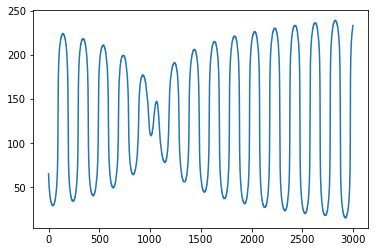

In [21]:
plt.plot(next(g).data[0])

## Exponential Time Generation zzz...

In [42]:
%pdb

Automatic pdb calling has been turned ON


In [47]:
x[:,:1024].size(1)

1024

CPU times: user 2.87 s, sys: 1.55 s, total: 4.41 s
Wall time: 4.41 s


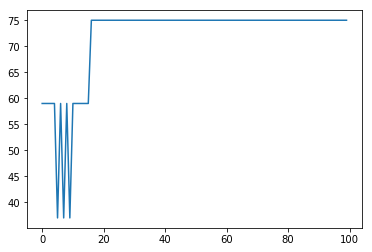

In [62]:
%time gen_wave = wavenet.generate(x[:,-1:], maxlen=100)
plt.plot(gen_wave.data[0]);